In [161]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Concatenate, UpSampling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

def create_unet_model(input_size=(128, 128, 3), num_classes=1, segmentation_type='binary'):
    # Base preentrenada de MobileNetV2
    base_model = MobileNetV2(input_shape=input_size, include_top=False)
    
    # Capas de interés del modelo base para la conexión
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Crear el modelo de extracción de características
    down_stack = Model(inputs=base_model.input, outputs=layers)
    down_stack.trainable = False

    # Definición de la parte ascendente del U-Net
    up_stack = [
        UpSampling2D((2, 2)),  # 4x4 -> 8x8
        UpSampling2D((2, 2)),  # 8x8 -> 16x16
        UpSampling2D((2, 2)),  # 16x16 -> 32x32
        UpSampling2D((2, 2)),  # 32x32 -> 64x64
    ]

    inputs = tf.keras.layers.Input(shape=input_size)
    x = inputs

    # Descenso en el U-Net
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Ascenso en el U-Net y concatenación con las capas de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # Capa final de convolución dependiendo del tipo de segmentación
    if segmentation_type == 'binary':
        x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        x = Conv2D(num_classes, 3, padding='same', activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'

    model = Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model

# Configuración del modelo
model = create_unet_model(segmentation_type='nobynary')

In [162]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar el mismo seed para las imágenes y las máscaras
seed = 1  # Puede ser cualquier número

# Generadores para las imágenes y las máscaras con el mismo seed
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes
image_generator = image_datagen.flow_from_directory(
    '/home/luishuingo/semantics_segmentation/Floor-Segmentation-1/train/images',
    class_mode=None,
    color_mode='rgb',
    target_size=(128, 128),
    batch_size=8,
    seed=seed)

# Cargar máscaras
mask_generator = mask_datagen.flow_from_directory(
    '/home/luishuingo/semantics_segmentation/Floor-Segmentation-1/train/masks',
    class_mode=None,
    color_mode='grayscale',
    target_size=(128, 128),
    batch_size=8,
    seed=seed)

val_image_generator = image_datagen.flow_from_directory(
    '/home/luishuingo/semantics_segmentation/Floor-Segmentation-1/val/images',
    class_mode=None,
    color_mode='rgb',
    target_size=(128, 128),
    batch_size=8,
    seed=seed)

val_mask_generator = mask_datagen.flow_from_directory(
    '/home/luishuingo/semantics_segmentation/Floor-Segmentation-1/val/masks',
    class_mode=None,
    color_mode='grayscale',
    target_size=(128, 128),
    batch_size=8,
    seed=seed)

# Función para combinar generadores
def combine_generators(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

# Combinar generadores
train_generator = combine_generators(image_generator, mask_generator)
val_generator = combine_generators(val_image_generator, val_mask_generator)


Found 338 images belonging to 1 classes.
Found 338 images belonging to 1 classes.
Found 48 images belonging to 1 classes.
Found 48 images belonging to 1 classes.


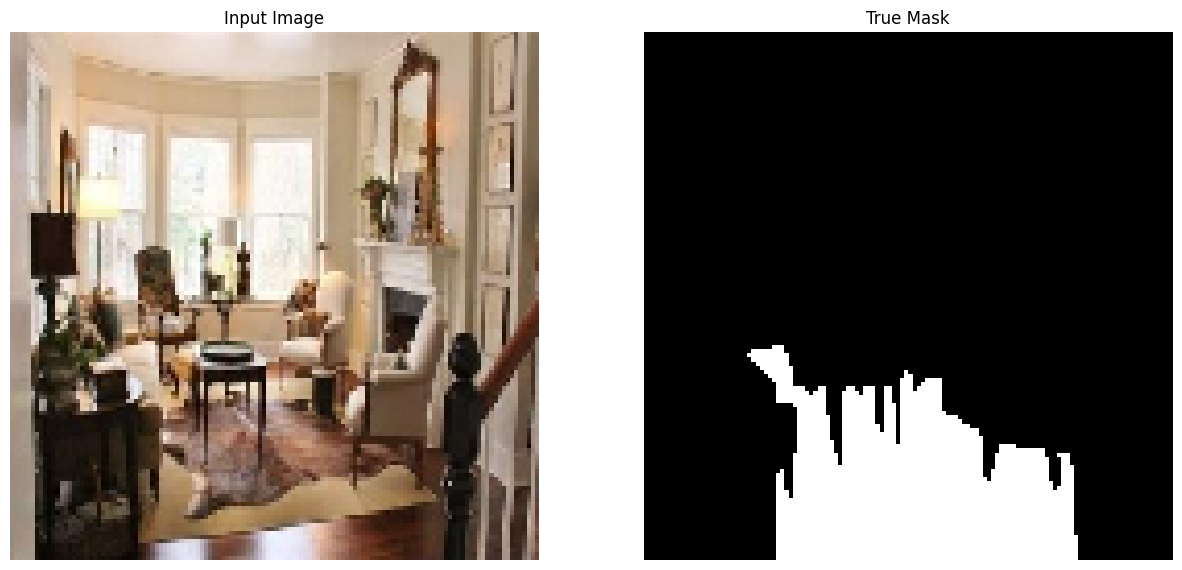

In [164]:
# Mostramos un ejemplo de imagen y máscara con su respectiva clase
import matplotlib.pyplot as plt
import numpy as np

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.squeeze(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

for image, mask in train_generator:
    sample_image, sample_mask = image[0], mask[0]
    break
display([sample_image, sample_mask])

In [165]:
for images, masks in train_generator:
    print(images.shape, masks.shape)  # Verificar dimensiones
    print(images.dtype, masks.dtype)  # Verificar tipos de datos
    # Mostramos el nombre de las clases
    
    break  # Solo inspeccionar el primer lote


(8, 128, 128, 3) (8, 128, 128, 1)
float32 float32


In [170]:
x, y = next(train_generator)
print("Shape of the images:", x.shape)  # Debe ser (batch_size, 128, 128, 3)
print("Shape of the masks:", y.shape)  # Debe ser (batch_size, 128, 128, 1) o (batch_size, 128, 128) para segmentación binaria

# Verificar el tipo de las máscaras si estás usando sparse_categorical_crossentropy
if y.dtype != 'int32' and y.dtype != 'int64':
    print("Las máscaras deben ser de tipo entero para sparse_categorical_crossentropy.")


Shape of the images: (8, 128, 128, 3)
Shape of the masks: (8, 128, 128, 1)


In [169]:
# Generador para las máscaras sin rescalar
mask_datagen = ImageDataGenerator()

# Cargar máscaras
mask_generator = mask_datagen.flow_from_directory(
    '/home/luishuingo/semantics_segmentation/Floor-Segmentation-1/train/masks',
    class_mode=None,
    color_mode='grayscale',
    target_size=(128, 128),
    batch_size=8,
    seed=seed)

# Función para combinar generadores y convertir máscaras a enteros
def combine_generators(gen1, gen2):
    while True:
        # Obtener el lote de imágenes y máscaras
        x = next(gen1)
        y = next(gen2)
        # Asegurarse de que las máscaras sean enteros
        y = y.astype('int32')
        yield (x, y)

# Combinar generadores
train_generator = combine_generators(image_generator, mask_generator)
val_generator = combine_generators(val_image_generator, val_mask_generator)


Found 338 images belonging to 1 classes.


In [171]:
# Parámetros de entrenamiento
num_epochs = 30  # Puedes ajustar esto según tus necesidades

# Entrenamiento del modelo
history = model.fit(
    train_generator, 
    epochs=num_epochs, 
    validation_data=val_generator, )


Epoch 1/30


2023-11-11 19:51:29.239792: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node Equal defined at (most recent call last):
  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_1318440/573337367.py", line 5, in <module>

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/training.py", line 1131, in train_step

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/training.py", line 1225, in compute_metrics

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/metrics/accuracy_metrics.py", line 395, in binary_accuracy

  File "/home/luishuingo/anaconda3/envs/tf_seg/lib/python3.9/site-packages/keras/src/utils/metrics_utils.py", line 932, in binary_matches

required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_81775]